<a href="https://colab.research.google.com/github/Debdatta1105/Income-Prediction/blob/main/data_mining_us_census.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install eli5
!pip install pyod


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=30edf1d09117dfa3881b37a93abf21d3b77b3a254e22725a0a67c9f09d9d6fe4
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=437cadff1629186d8edfe06486b2445d9d0a9ee85469b5da52e932af868f2705
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [ ]:
# importing libraries for reading and working with the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
# import machine learning libraries for classification and evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report,silhouette_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold,train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import normalize,StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from pyod.models.knn import KNN
# displaying decision trees
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree

In [ ]:
# takes any pandas dataframe and converts all columns containing categorical data to numeric data
def convert_df_to_numeric(df):
	for col in df.columns:
		if df[col].dtype == 'object':
			df[col] = df[col].astype('category')
			df[col] = df[col].cat.codes

# Define a function to train and evaluate decision tree models
def create_classification_model(X,y): #function to create variables and split them
  # Define the training-test splits
  splits = [(0.8, 0.2), (0.6, 0.4), (0.5, 0.5)]
  # Train and evaluate models with diffrent splits
  for split in splits:
      print('Training-test split: {}-{}'.format(split[0], split[1]))
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split[1], random_state=42)
      accuracy,mse,rmse,list1,list2 = DecisionTreeModel(X_train,X_test, y_train, y_test)
      evaluation(accuracy,mse,rmse)
  return(list1,list2)

# Define a function to print evaluation
def evaluation(accuracy,mse,rmse):
      print(f"Model accuracy: {accuracy}%")
      print(f"Mean Squared error: {mse} and Root Mean Squared error: {rmse}")
      print('-' * 50)

# Functoin to build decision tree model
def DecisionTreeModel(x_train, x_test, y_train, y_test,K): ## creating a decision tree classifier
    # Train a decision tree classifier
    dtc = DecisionTreeClassifier()
    dtc.fit(x_train, y_train)
    # Evaluate the model on the test set
    y_pred = dtc.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    rounded_accuracy = round(accuracy*100,2)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # Perform cross-validation and print mean accuracy and standard deviation
    cv_scores = cross_val_score(dtc, x_train, y_train, cv= K)
    #Storing accuracy and training data
    list1 = []
    list2 = []
    list1.append(accuracy)
    list2.append([x_train,y_train,y_test,y_pred])
    return(rounded_accuracy,round(mse,2),round(rmse,2),cv_scores.mean(),cv_scores.std(),list1,list2)

def DecisionTreeModel(x_train, x_test, y_train, y_test): ## creating a decision tree classifier
    # Train a decision tree classifier
    dtc = DecisionTreeClassifier()
    dtc.fit(x_train, y_train)
    # Evaluate the model on the test set
    y_pred = dtc.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    #Storing accuracy and training data
    list1 = []
    list2 = []
    list1.append(accuracy)
    list2.append([x_train,y_train,y_test,y_pred])
    return(round(accuracy*100,2),round(mse,2),round(rmse,2),list1,list2)

#Creating a function to perform k folds
def kFolds_function(folds,x,y):
  kf = KFold(n_splits=folds)
  n = 1
  list1 = []
  list2 = []

  for train, test in kf.split(x): #split then find training accuracy
    x_train, x_test = x.iloc[train], x.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    accuracy,mse,rmse,list3,list4 = DecisionTreeModel(x_train, x_test, y_train, y_test)
    list1.append(train)
    list2.append(accuracy)
    n+=1
  print(f"maximum accuracy for {folds} folds is: {max(list2)}%")
  print(f"Mean Squared error: {mse} and Root Mean Squared error: {rmse}")
  print('-' * 50)
  return list1,list2,x_test,y_test

# returns the optimal k value determined by the silhouette coefficient
def get_optimal_k(X):
    # compute the Silhouette Coefficient for each K value
    k_values = range(2, 10)
    silhouette_scores = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
        silhouette_scores.append(silhouette_score(X, kmeans.fit_predict(X)))

    # find the optimal K value
    optimal_k = k_values[np.argmax(silhouette_scores)]
    print('Optimal number of clusters:', optimal_k)
    return optimal_k


# Define a function to plot the clusters
def plot_clusters(df, labels, title):
    plt.scatter(df.loc[:, 0], df.loc[:, 1], c=labels)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(title)
    plt.show()

# measure distance from data point to kmean centroid a
def distance_from_center(pred,income, label):
    cent_pred =  kmeans.cluster_centers_[label,0]
    cent_income =  kmeans.cluster_centers_[label,1]
    distance = np.sqrt((pred - cent_pred) ** 2 + (income - cent_income) ** 2)
    return np.round(distance, 3)



In [ ]:
# read csv from source directly
headers = ['age', 'workclass', 'Final_weight', 'education', 'education-num', 'marital-status', 'occupation',
           'relationship','race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=headers,
                   na_values=' ?')
# Find data shape
rows_count = data.shape[0]
print("Number of observations: ",rows_count)
print("Number of columns: ",data.shape[1])

Number of observations:  32561
Number of columns:  15


In [ ]:
# Make a copy of data to be pre processed
pre_processing = data.copy()
print("Data description:\n", pre_processing.describe())
# We can clearly spot that  capital-gain first 3 quantiles are zeros and max is very high value

print(f"There are {pre_processing['capital-gain'].value_counts()[99999]} rows filled with 99999 ")
display(pre_processing.boxplot(column='capital-gain', return_type='axes'))
print("Based on below boxplot we can see that values don't exceed 45K ")
# find percentages of items filled with zero
print(f"More than {round(pre_processing['capital-gain'].value_counts()[0]/pre_processing.shape[0]*100,2)}% of the capital gain values are zeros")
# Cleaning outliers 159 values are written as 99999
print("Column mode: ",pre_processing["capital-gain"].mode()[0])
print("Column median: ",pre_processing["capital-gain"].median())

# we will replace thhem with zero which is the mode, median and 90% of rows
pre_processing["capital-gain"].replace(99999, 0, inplace=True)

# Check for missing data
print("Count of null values", pre_processing.isnull().sum().sum())
# Filling null values
pre_processing["occupation"].fillna("Unemployed", inplace=True)
pre_processing["workclass"].fillna("Unemployed", inplace=True)
pre_processing["native-country"].fillna("unaffiliated", inplace=True)
print("Count of remaining null values after cleaning", pre_processing.isnull().sum().sum())
# Transform income variable to binary numeric variable
pre_processing['income'] = pre_processing['income'].apply(lambda x: 1 if x == ' >50K' else 0)
# removing dublicates
pre_processing = pre_processing.drop_duplicates()
print(f"There was {rows_count - pre_processing.shape[0]} dublicates that were dropped")
# convert remaining categorical features
convert_df_to_numeric(pre_processing)
adult_data = pre_processing.copy()

Data description:
                 age  Final_weight  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  
There are 159 rows filled with 99999 


<Axes: >

Based on below boxplot we can see that values don't exceed 45K 
More than 91.67% of the capital gain values are zeros
Column mode:  0
Column median:  0.0
Count of null values 4262
Count of remaining null values after cleaning 0
There was 24 dublicates that were dropped


In [ ]:
# Split the dataset into training and testing sets
X = adult_data.drop('income', axis=1)
y = adult_data['income']

#Vizulize which features have most effects on predicting income
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
perm = PermutationImportance(dtc, random_state = 0).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

In [ ]:
# pick most effects features and find accuracy of train-test
features = ['relationship','capital-gain','education-num','age','capital-loss'
                ,'hours-per-week', 'occupation','marital-status','workclass','sex']
X = adult_data[features]

accuracy_list,training_list = create_classification_model(X,y)

#Finding most accurate number of folds
for i in [5,10]:
  kFolds_function(i,X,y)

Training-test split: 0.8-0.2
Model accuracy: 80.87%
Mean Squared error: 0.19 and Root Mean Squared error: 0.44
--------------------------------------------------
Training-test split: 0.6-0.4
Model accuracy: 81.19%
Mean Squared error: 0.19 and Root Mean Squared error: 0.43
--------------------------------------------------
Training-test split: 0.5-0.5
Model accuracy: 81.2%
Mean Squared error: 0.19 and Root Mean Squared error: 0.43
--------------------------------------------------
maximum accuracy for 5 folds is: 82.05%
Mean Squared error: 0.18 and Root Mean Squared error: 0.42
--------------------------------------------------
maximum accuracy for 10 folds is: 82.2%
Mean Squared error: 0.19 and Root Mean Squared error: 0.43
--------------------------------------------------


In [ ]:
# Plotting decission tree with 10 folds as it is the most accurate method.
list1,list2,x_test,y_test = kFolds_function(10,X,y)
max_index = list2.index(max(list2)) #picking most accurate fold
model = DecisionTreeClassifier() #create classifier
model.fit(X.iloc[list1[max_index]], y.iloc[list1[max_index]])

# Visualizing the decision tree
#   1. Text: sklearn.tree.export_text
#   2. Pictorial: sklearn.tree.plot_tree method (import matplotlib)
#   3. Dot image: sklearn.tree.export_graph ( import graphviz)
#   4. dtreeviz: dtreeviz and pgraphviz
# Text

text_viz = export_text(model, feature_names=features)
# Pictorial
fig = plt.figure(figsize=(56, 70))
_ = plot_tree(model, feature_names=features, filled=True)
fig.savefig("Tree_image.png")

maximum accuracy for 10 folds is: 82.11%
Mean Squared error: 0.19 and Root Mean Squared error: 0.43
--------------------------------------------------


In [ ]:
# Outlier detections
# Normlize features for more accurate kmean & KNN models
data = pd.DataFrame(normalize(pre_processing.copy()))

# The first approach is to make first approach to find outlier using distance with kmeans and knn algorithms
# and second approach is building decision tree then use isolation forest algorithm
KNN_data = data.copy()
Forest_data = data.copy()
kmean_data = data.copy()

# Scale the numerical features
scaler = StandardScaler()
kmean_data = scaler.fit_transform(kmean_data)

# Perform principal component analysis (PCA) to reduce dimensionality
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(kmean_data))

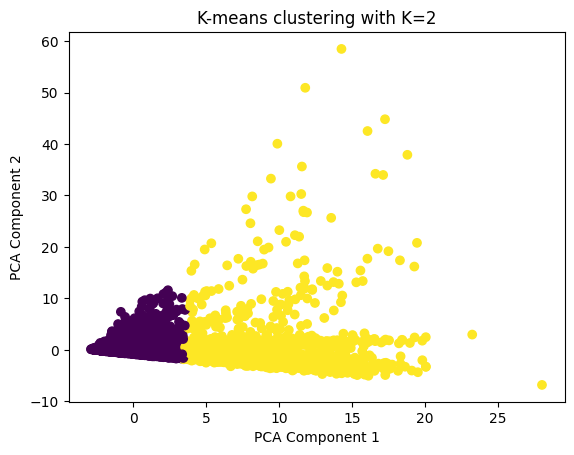

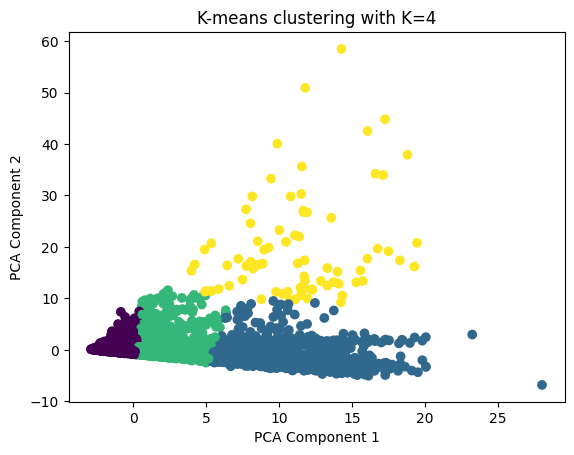

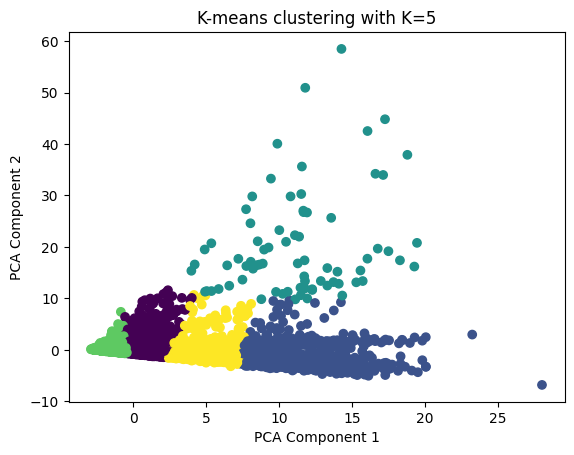

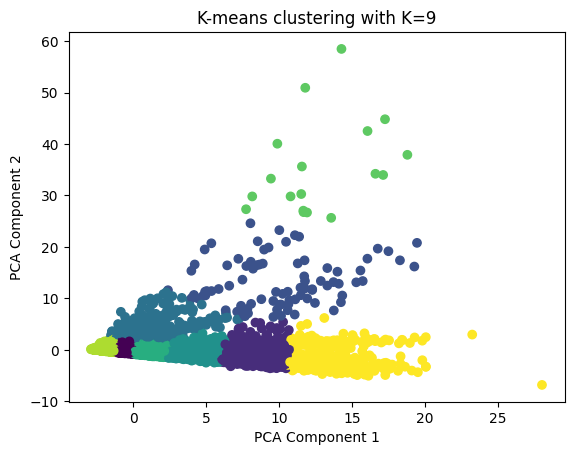

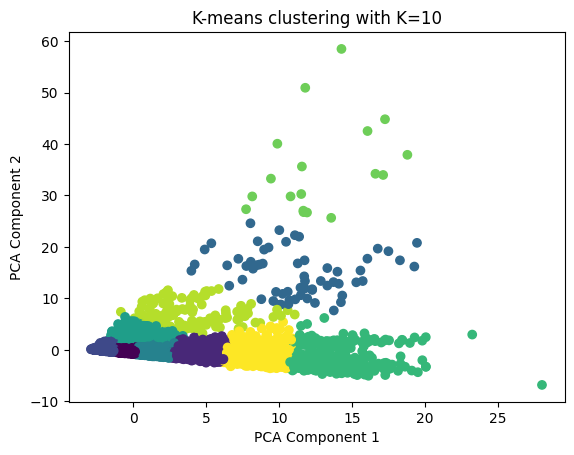

In [ ]:
# Compute the Silhouette Coefficient for each K value
k_values = range(2, 11)
silhouette_scores = []
for k in k_values:
  kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
  labels = kmeans.fit_predict(df_pca)
  silhouette_scores.append(silhouette_score(df_pca, labels))
  # Visualize the clusters
  plot_clusters(df_pca, kmeans.labels_, 'K-means clustering with K={}'.format(k))

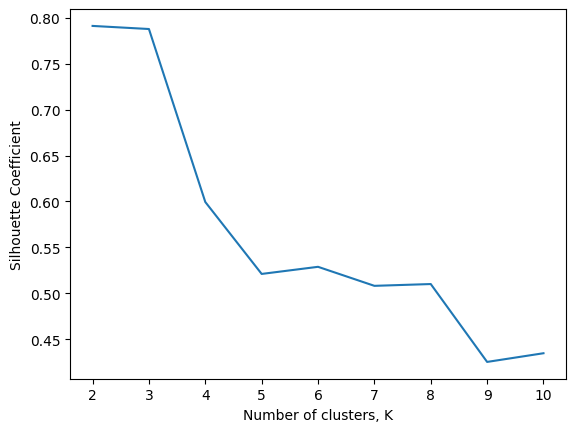

Silhouette Coefficient for K = 2:  0.7911196644559887
Silhouette Coefficient for K = 3:  0.7877538989926175
although K = 2 has higher Silhouette Coefficients we will chose K = 3 model because it's vizulized model is better


In [ ]:
# plot the Silhouette Coefficients for each K value
plt.plot(k_values, silhouette_scores)
plt.xlabel('Number of clusters, K')
plt.ylabel('Silhouette Coefficient')
plt.show()

# find the optimal K value
print("Silhouette Coefficient for K = 2: ",silhouette_scores[0])
print("Silhouette Coefficient for K = 3: ",silhouette_scores[1])
max_score = k_values[np.argmax(silhouette_scores)]
print("although K = 2 has higher Silhouette Coefficients we will chose K = 3 model because it's vizulized model is better")

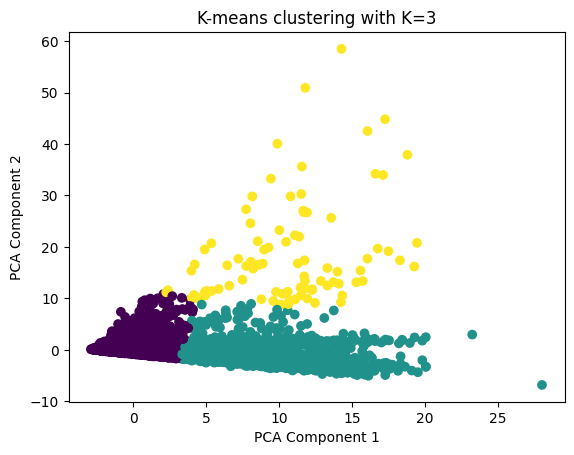

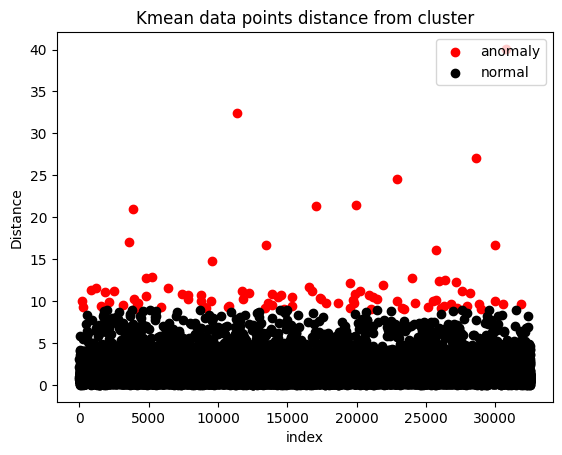

In [ ]:
# Apply kmean clustring for outlier detection
kmeans = KMeans(n_clusters = 3, init='k-means++', max_iter=300, n_init=10, random_state=0)
labels = kmeans.fit_predict(df_pca)

# Visualize the clusters
plot_clusters(df_pca, kmeans.labels_, 'K-means clustering with K={}'.format(3))

# find distances of data points from the center of thier clusters
df_pca['label'] = kmeans.labels_
df_pca['distance'] = distance_from_center(df_pca.iloc[:, 0], df_pca.iloc[:, 1],df_pca['label'])

# Creating scatter plot to show data points location from kmean disctance scores
kmean_anom = df_pca[df_pca['distance'] >=  9]
kmean_norm = df_pca[df_pca['distance'] <  9]

plt.scatter(kmean_anom.index.values.tolist(),kmean_anom['distance'], c ="red" ,label = 'anomaly')
plt.scatter(kmean_norm.index.values.tolist(),kmean_norm['distance'], c ="black",label = 'normal')
plt.legend(loc="upper right")
plt.xlabel('index')
plt.ylabel('Distance')
plt.title("Kmean data points distance from cluster")
plt.show()

# We will use the threshold as 9 based on the plot we can see the majority of data points are below it and only few points above it
df_pca['Kmean_outlier'] = np.where(df_pca['distance'] < 9 , 'Normal', 'Outlier')

KNN autmatic threshold is: 0.00238 and any value further in distance will be labeled as anomaly


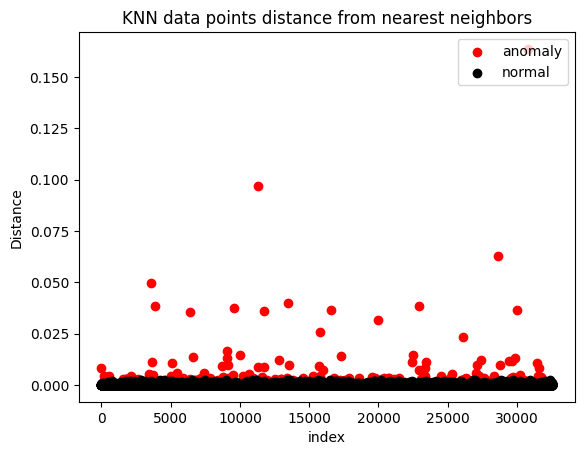

In [ ]:
# Apply KNN for outlier detection
knn = KNN(contamination=0.005)
knn.fit(KNN_data)
y_train_scores = knn.decision_function(data)
KNN_data['KNN_anomaly_Score'] = y_train_scores
print(f"KNN autmatic threshold is: {round(knn.threshold_,5)} and any value further in distance will be labeled as anomaly")

# Creating scatter plot to show data points anomaly score for KNN
knn_anom = KNN_data[KNN_data['KNN_anomaly_Score'] >  knn.threshold_]
knn_norm = KNN_data[KNN_data['KNN_anomaly_Score'] <  knn.threshold_]

plt.scatter(knn_anom.index.values.tolist(),knn_anom['KNN_anomaly_Score'], c ="red" ,label = 'anomaly')
plt.scatter(knn_norm.index.values.tolist(),knn_norm['KNN_anomaly_Score'], c ="black",label = 'normal')
plt.legend(loc="upper right")
plt.xlabel('index')
plt.ylabel('Distance')
plt.title("KNN data points distance from nearest neighbors")
plt.show()

# Use KNN autmatic threshold to classify anomaly
KNN_data['KNN_outlier'] = np.where(KNN_data['KNN_anomaly_Score'] < knn.threshold_, 'Normal', 'Outlier')